<a href="https://colab.research.google.com/github/pavel7479/For_resume/blob/main/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%BD%D0%B0%D0%B3%D1%80%D0%B0%D0%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Концепция системы наград:
* Если сделка приносит прибыль, агент получает положительное вознаграждение, пропорциональное размеру прибыли.
* Если сделка приводит к убыткам, агент получает отрицательное вознаграждение, пропорциональное размеру убытков.

### Пути улучшения системы наград:
Стимулы за удержание позиции (HOLD):
* Агент получает небольшое положительное вознаграждение за удержание позиции, если рынок движется в его пользу.
* Агент получает небольшое отрицательное вознаграждение за удержание позиции, если рынок движется против него.

Штрафы за неправильные действия:
* Если агент открывает позицию в неблагоприятный момент (например, покупка на максимуме или продажа на минимуме), он получает штраф.
* Штраф за частые открытия и закрытия позиций без явной выгоды, чтобы стимулировать более обдуманное поведение.

Динамическая шкала награды:
* Масштабирование может быть заменено на динамическое, зависящее от волатильности или среднего объёма.

В торговле учитываются комиссии и спреды (в коде это не реализовано). Эти издержки можно вычитать из награды при открытии/закрытии позиций.



# Метрики для оценки эффективности системы наград:
### Накопленная прибыль: Оценивает общую прибыль, полученную агентом за период времени.
### Просадка: Анализирует максимальную просадку капитала, чтобы оценить уровень риска стратегии.
### Коэффициент Шарпа: Измеряет соотношение доходности к риску, что важно для определения эффективности стратегии.
###  Процент выигрышных сделок: Оценивает долю прибыльных сделок от общего количества.
### Средняя награда: Показывает, насколько эффективно агент зарабатывает награды.


## Ниже я привожу код с метрикой DQN (Deep Q-Learning Network) т.к. она хорошо подходит для задач с конечным набором действий (BUY, SELL, HOLD).

# Полный код

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import gym
from gym import spaces

Mounted at /content/drive


Файл for_model.xlsx
можно скачать по ссылке
https://docs.google.com/spreadsheets/d/1v_VlboFRa2hS-sf9uh2t5ZoBmEunGIVh/edit?usp=sharing&ouid=106335427595044925029&rtpof=true&sd=true


In [ ]:
# Путь к файлу на моём google диске
input_file = '/content/drive/MyDrive/Forex/файлы_преобразованные_для_подачи_в_Модель/for_model.xlsx'

In [ ]:
data = pd.read_excel(input_file)
data

,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,SPREAD
0,2024.01.02,09:00:00,1.27360,1.27363,1.27282,1.27303,2925,21
1,2024.01.02,10:00:00,1.27302,1.27430,1.27259,1.27314,6595,21
2,2024.01.02,11:00:00,1.27315,1.27589,1.27286,1.27487,8227,21
3,2024.01.02,12:00:00,1.27486,1.27553,1.27162,1.27166,6333,21
4,2024.01.02,13:00:00,1.27165,1.27177,1.26913,1.26942,6991,21
...,...,...,...,...,...,...,...,...
4974,2024.10.23,04:00:00,1.29759,1.29775,1.29703,1.29759,6554,21
4975,2024.10.23,05:00:00,1.29760,1.29894,1.29757,1.29878,5167,21
4976,2024.10.23,06:00:00,1.29879,1.29908,1.29814,1.29844,5254,21
4977,2024.10.23,07:00:00,1.29845,1.29878,1.29793,1.29877,4802,21


In [ ]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 22.9 MB/s eta 0:00:00


In [ ]:
!pip install 'shimmy>=2.0'

In [ ]:
# Создаём среду для действий агента
class ForexTradingEnv(gym.Env):
    def __init__(self, data):
        super(ForexTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.balance = 10000
        self.position = None
        self.entry_price = 0

        # Пространство состояний и действий
        self.action_space = spaces.Discrete(3)  # BUY, HOLD, SELL
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)
    def reset(self):
        self.current_step = 0
        self.balance = 1000
        self.position = None
        self.entry_price = 0
        return self._get_observation()

    # Определяем награды
    def step(self, action):
        reward = 0
        done = False

        current_close = self.data['CLOSE'].iloc[self.current_step]

        if action == 1:  # BUY
            if self.position == "SHORT":
                profit = self.entry_price - current_close - 0.00021
                reward = profit * 10000
                self.balance += reward
                self.position = None
            elif self.position is None:
                self.position = "LONG"
                self.entry_price = current_close

        elif action == 2:  # SELL
            if self.position == "LONG":
                profit = current_close - self.entry_price - 0.00021
                reward = profit * 10000
                self.balance += reward
                self.position = None
            elif self.position is None:
                self.position = "SHORT"
                self.entry_price = current_close

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True

        return self._get_observation(), reward, done, {"balance": self.balance, "position": self.position}

    def _get_observation(self):
        # Выбираем только числовые данные (6 столбцов)
        numeric_data = self.data.iloc[self.current_step][['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'SPREAD']]
        return numeric_data.values.astype(np.float32)


    def render(self, mode='human'):
        pass


In [ ]:
# Класс для подсчета метрик
class TradingMetrics:
    def __init__(self):
        self.rewards = []  # Список для хранения наград
        self.actions = []  # Список действий

    def update(self, reward, action):
        self.rewards.append(reward)
        self.actions.append(action)

    def calculate_metrics(self):
        total_profit = sum(self.rewards)
        avg_profit = total_profit / len(self.rewards) if self.rewards else 0
        profit_std = (sum((x - avg_profit) ** 2 for x in self.rewards) / len(self.rewards)) ** 0.5 if self.rewards else 0
        return {
            "Total Profit": total_profit,
            "Average Profit": avg_profit,
            "Profit StdDev": profit_std,
            "Actions Distribution": {0: self.actions.count(0), 1: self.actions.count(1), 2: self.actions.count(2)},
        }

In [ ]:
from stable_baselines3 import PPO, DQN

# Инициализация данных и среды
forex_df = pd.DataFrame(data)

# Преобразование данных в формат среды
forex_df['CLOSE'] = forex_df['CLOSE'].astype(float)
env = ForexTradingEnv(forex_df)

# Создание модели PPO
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Тестирование обученной модели
obs = env.reset()
done = False
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    print(f"Action: {action}, Reward: {reward}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Reward: 0
Action: 0, Re

In [ ]:
metrics = TradingMetrics()

# Тестирование обученной модели с расчетом метрик
obs = env.reset()
done = False
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    metrics.update(reward, action)

# Вывод метрик
results = metrics.calculate_metrics()
print("Trading Metrics Results:", results)


Trading Metrics Results: {'Total Profit': -78.799999999995, 'Average Profit': -0.01582965046203194, 'Profit StdDev': 7.292379394445592, 'Actions Distribution': {0: 4811, 1: 89, 2: 78}}


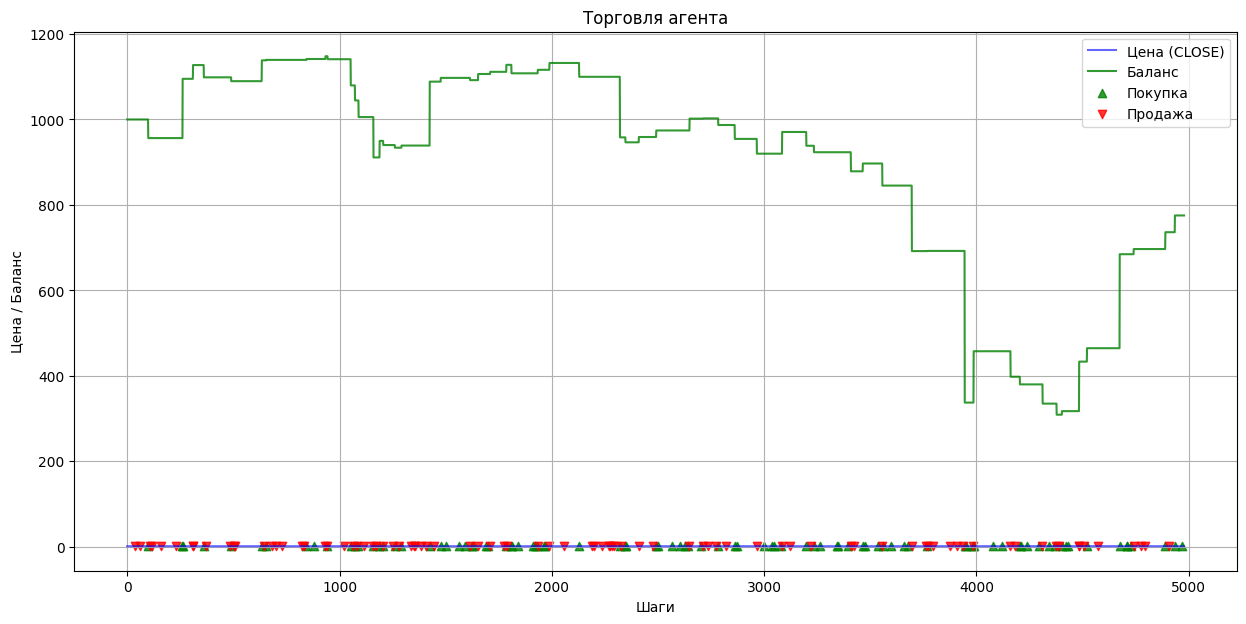

In [ ]:
import matplotlib.pyplot as plt

# Добавляем действия агента и баланс в DataFrame
obs = env.reset()
done = False
actions = []
balances = [env.balance]  # Начальный баланс
prices = []  # Для отображения цены CLOSE
while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    actions.append(action)
    balances.append(info["balance"])
    prices.append(env.data['CLOSE'].iloc[env.current_step])

# Построение графика
plt.figure(figsize=(15, 7))
plt.plot(prices, label="Цена (CLOSE)", color='blue', alpha=0.6)
plt.plot(balances, label="Баланс", color='green', alpha=0.8)

# Отмечаем действия агента
buy_signals = [i for i, a in enumerate(actions) if a == 1]  # BUY
sell_signals = [i for i, a in enumerate(actions) if a == 2]  # SELL

plt.scatter(buy_signals, [prices[i] for i in buy_signals], label="Покупка", color='green', marker='^', alpha=0.8)
plt.scatter(sell_signals, [prices[i] for i in sell_signals], label="Продажа", color='red', marker='v', alpha=0.8)

plt.title("Торговля агента")
plt.xlabel("Шаги")
plt.ylabel("Цена / Баланс")
plt.legend()
plt.grid()
plt.show()


# Выводы:
Профит есть, но маленькая велечина среднего профита и большой разброс

## Дальнейшие шаги для улучшения:
### Оптимизировать стратегию:

Увеличить награду за сделки с более высокой прибылью и уменьшить за действия, которые приводят к убыткам.
Экспериментировать с более долгими периодами обучения, чтобы агент лучше научился предсказывать эффективные действия.

### Стабилизировать профит:
Добавить штрафы за действия, приводящие к большим убыткам.
Пересмотреть функцию награды.

### Подключить дополнительные метрики:

Включить коэффициент выигрыша (win rate) — долю прибыльных сделок от общего числа.
Рассчитать максимальную просадку (max drawdown) для оценки рисков стратегии.